In [15]:
import os

import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import word2vec

from sklearn import svm,neighbors,ensemble,linear_model, naive_bayes
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, label_binarize
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
from sklearn.multiclass import OneVsRestClassifier
from wordcloud import WordCloud

from collections import Counter

%matplotlib inline

import warnings

warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')

For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

    Data cleaning / processing / language parsing
    Create features using two different NLP methods: For example, BoW vs tf-idf.
    Use the features to fit supervised learning models for each feature set to predict the category outcomes.
    Assess your models using cross-validation and determine whether one model performed better.
    Pick one of the models and try to increase accuracy by at least 5 percentage points.



###  Data cleaning / processing / language parsing

In [16]:
#load data: 6 lectures from MIT open courseware from similar yet different subjects (math)
#ccs were extrated with inspect element>network>timedtext saved as xml and cleaned in sublime
#removed statement about donations and mit courseware

folder = r"/root/Documents/DSviz/unit4/"

# Set name of the file
filename = "vandijk.txt"
fp = os.path.join(folder, filename)
# Read all contents of the file:
with open(fp, "r") as infile:
    vandijk = infile.read()
filename = 'Leighton.txt'    
fp = os.path.join(folder, filename)
with open(fp, "r") as infile:
    leighton = infile.read()
filename = 'strang.txt'    
fp = os.path.join(folder, filename)
with open(fp, "r") as infile:
    strang = infile.read()

In [17]:
print(vandijk [:140])
print(leighton[:140])
print(strang[:140])

  PROFESSOR: We're going to talk
about inclusion-exclusion which 
 is a generalization
of what we did 
 at the end of last lecture,
which wa
 PROFESSOR: Last time
we defined the expected 
 value of a random variable. 
 And we talked about a lot of
ways it could be computed. 
 We p
 
 
 
 PROFESSOR: OK. 
 Hi. 
 I thought I'd give a short
lecture about how logarithms 
 are actually used. 
 So a little bit practical. 
 An


In [18]:
# Some elements need to be cleaned up, [.*] to be removed (audiance laughter,inaudible etc).
#in the second Marten Van Dijk is present instead of PROFESSOR.

In [19]:
vandijk = re.sub('MARTEN VAN DIJK', 'PROFESSOR',vandijk)

In [20]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'. 
    text = re.sub(r'--',', ',text) # i left this because the lectures are riddled with it. replace with comma
    text = re.sub("[\[].*?[\]]", "", text) #remove in audible
    text = ' '.join(text.split())
    return text

In [21]:
vandijk = text_cleaner(vandijk)
leighton = text_cleaner(leighton)
strang = text_cleaner(strang)

In [22]:
print(leighton[:500])

PROFESSOR: Last time we defined the expected value of a random variable. And we talked about a lot of ways it could be computed. We proved all sorts of equivalent definitions. Today, we're going to keep talking about expectation. And we're going to start with an example that talks about the expected number of events that you expect to have occur. And it's a generalization of what we did with Chinese appetizer and hat check from last time. We're going to call this theorem 1. If you have a probabi


In [23]:
nlp = spacy.load('en')
leighton_doc = nlp(leighton)

In [24]:
strang_doc = nlp(strang)

In [25]:
vandijk_doc = nlp(vandijk)

In [28]:
lei_sents = [[sent, "Leighton"] for sent in leighton_doc.sents]
van_sents = [[sent, "Van Dijk"] for sent in vandijk_doc.sents]
sta_sents = [[sent, "Strang"] for sent in strang_doc.sents]

In [29]:
sentences = pd.DataFrame(lei_sents + van_sents + sta_sents)
sentences.head()

,0,1
0,"(PROFESSOR, :)",Leighton
1,"(Last, time, we, defined, the, expected, value...",Leighton
2,"(And, we, talked, about, a, lot, of, ways, it,...",Leighton
3,"(We, proved, all, sorts, of, equivalent, defin...",Leighton
4,"(Today, ,, we, 're, going, to, keep, talking, ...",Leighton


In [30]:
len(sentences)

4618

### Create features using two different NLP methods: For example, BoW vs tf-idf.

#### Bag of Words

In [37]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]

In [40]:
lei_words = bag_of_words(leighton_doc)
sta_words = bag_of_words(strang_doc)
van_words = bag_of_words(vandijk_doc)

In [41]:
common_words = set(lei_words + sta_words + van_words)

In [43]:
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
            
        
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [44]:
word_counts = bow_features(sentences,common_words)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500


In [45]:
word_counts.head()

,straightforward,forget,quietly,trial,dimensional,convey,hopeless,stay,express,lastly,...,pat,1/9,lousy,wheel,minus,inductive,scale,finite,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(PROFESSOR, :)",Leighton
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Last, time, we, defined, the, expected, value...",Leighton
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(And, we, talked, about, a, lot, of, ways, it,...",Leighton
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(We, proved, all, sorts, of, equivalent, defin...",Leighton
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Today, ,, we, 're, going, to, keep, talking, ...",Leighton


Logistic Regression (ridge)

In [398]:
X = word_counts.drop(['text_sentence','text_source'],1)
y = word_counts['text_source']

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=43)

NameError: name 'X' is not defined

Training Score: 0.9159688131677736
Test Score: 0.8233766233766234
              precision    recall  f1-score   support

    Leighton       0.81      0.91      0.86       566
      Strang       0.93      0.63      0.75       222
    Van Dijk       0.81      0.80      0.81       367

   micro avg       0.82      0.82      0.82      1155
   macro avg       0.85      0.78      0.80      1155
weighted avg       0.83      0.82      0.82      1155



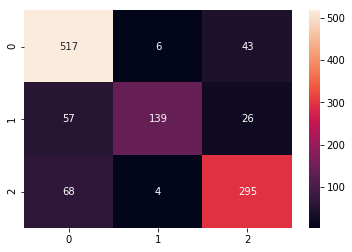

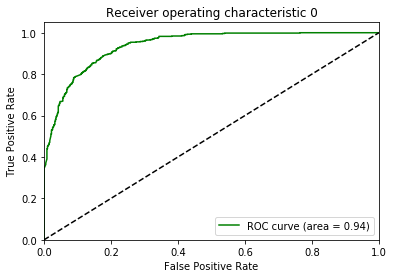

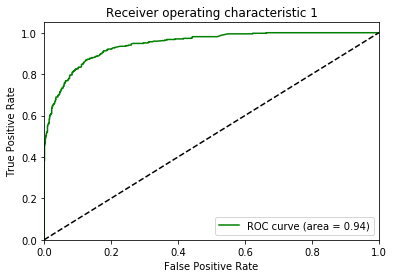

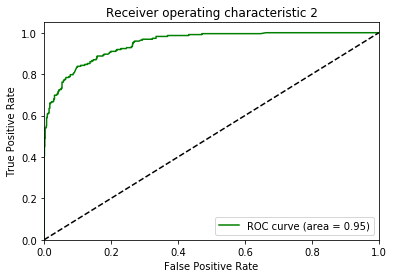

In [400]:
lrc = linear_model.LogisticRegression(C=.9,solver='lbfgs',multi_class='auto')
lrc.fit(X_train,y_train)
print("Training Score: {}".format(lrc.score(X_train,y_train)))
print("Test Score: {}".format(lrc.score(X_test,y_test)))
y_pred = lrc.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()
#look at OvR ROC curves for each class

y = label_binarize(y, classes=['Leighton','Van Dijk','Strang'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=43)
n_classes = 3

# classifier
clf = OneVsRestClassifier(linear_model.LogisticRegression(C=.9,solver='lbfgs',multi_class='auto'))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i],color='g', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

 SVM

Training Score: 0.9220329194340168
Test Score: 0.8181818181818182
              precision    recall  f1-score   support

    Leighton       0.80      0.89      0.85       566
      Strang       0.90      0.63      0.74       222
    Van Dijk       0.81      0.82      0.81       367

   micro avg       0.82      0.82      0.82      1155
   macro avg       0.84      0.78      0.80      1155
weighted avg       0.82      0.82      0.82      1155



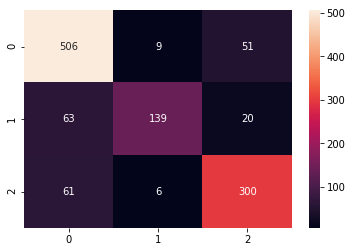

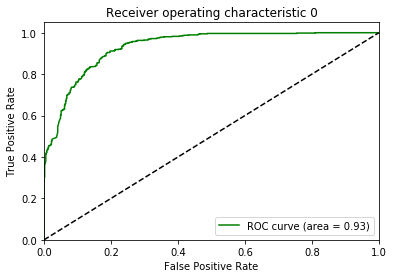

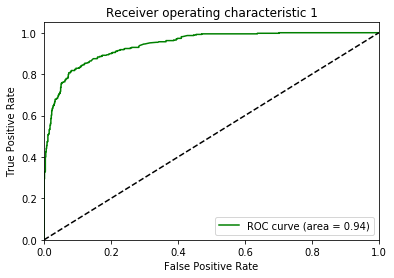

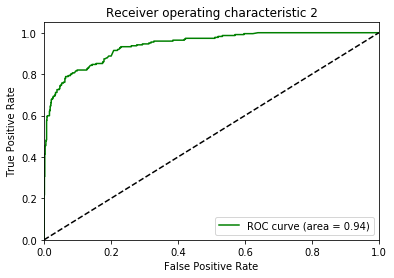

In [403]:
X = word_counts.drop(['text_sentence','text_source'],1)
y = word_counts['text_source']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=43)

svc = svm.SVC(kernel='linear',C=.9)
svc.fit(X_train,y_train)
print("Training Score: {}".format(svc.score(X_train,y_train)))
print("Test Score: {}".format(svc.score(X_test,y_test)))
y_pred = svc.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()

y = label_binarize(y, classes=['Leighton','Van Dijk','Strang'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=43)
n_classes = 3

# classifier
clf = OneVsRestClassifier(svc)
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i],color='g', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

Not as good as the Logistic Regression

## tf-idf

In [31]:
#more sentences 
lecture_paras= []
for i in sentences[0]:
    lecture_paras.append(str(i))


In [32]:
lecture_paras[:5]

['PROFESSOR:',
 'Last time we defined the expected value of a random variable.',
 'And we talked about a lot of ways it could be computed.',
 'We proved all sorts of equivalent definitions.',
 "Today, we're going to keep talking about expectation."]

In [33]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [39]:
lect_paras_tfidf = vectorizer.fit_transform(lecture_paras)
print("Number of features: %d" % lect_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(lect_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', vectorizer.inverse_transform(X_train_tfidf[5]))
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1271
Original sentence: [array(['order', 'better', 'need', 'define', 'definitions'], dtype='<U15')]
Tf_idf vector: {'order': 0.43953906127439807, 'better': 0.42388362157837867, 'need': 0.35999502661371463, 'define': 0.43708444991663636, 'definitions': 0.5536143544256066}


In [40]:
lei_sents1 = [[str(sent), "Leighton"] for sent in leighton_doc.sents]
van_sents1 = [[str(sent), "Van Dijk"] for sent in vandijk_doc.sents]
sta_sents1 = [[str(sent), "Strang"] for sent in strang_doc.sents]
new_df = pd.DataFrame(lei_sents1 + van_sents1 + sta_sents1)
new_df.head()

,0,1
0,PROFESSOR:,Leighton
1,Last time we defined the expected value of a r...,Leighton
2,And we talked about a lot of ways it could be ...,Leighton
3,We proved all sorts of equivalent definitions.,Leighton
4,"Today, we're going to keep talking about expec...",Leighton


In [46]:
new_df[0][5]

"And we're going to start with an example that talks about the expected number of events that you expect to have occur."

In [48]:
vectorizer.inverse_transform(X_train_tfidf[5])

[array(['order', 'better', 'need', 'define', 'definitions'], dtype='<U15')]

In [278]:
X_train1.iloc[17]

'This is , let me copy down ,'

In [276]:
#ok maybe we can move forward now

In [49]:
#declare features, target
X = new_df[0]
y = new_df[1]
#fit transform td-idf
X = vectorizer.fit_transform(X)
X = X.toarray() #convert to array for modeling

In [331]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=43)

### tf-idf with random forest

In [332]:
X_train.shape,X_test.shape

((3463, 1271), (1155, 1271))

In [333]:
rfc = ensemble.RandomForestClassifier(n_estimators=1200,max_depth=7,
                                      min_samples_leaf=4,min_samples_split=3,
                                      criterion='entropy')

rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [334]:
rfc.score(X_train,y_train)

0.5492347675425931

In [335]:
rfc.score(X_test,y_test)

0.5627705627705628

## Multinomial Naive Bayes w /tf-idf

In [336]:
mnb = naive_bayes.MultinomialNB()

In [337]:
mnb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [338]:
mnb.score(X_train,y_train)

0.8761189719896044

In [339]:
mnb.score(X_test,y_test)

0.8181818181818182

              precision    recall  f1-score   support

    Leighton       0.79      0.93      0.85       566
      Strang       0.97      0.56      0.71       222
    Van Dijk       0.82      0.80      0.81       367

   micro avg       0.82      0.82      0.82      1155
   macro avg       0.86      0.76      0.79      1155
weighted avg       0.83      0.82      0.81      1155



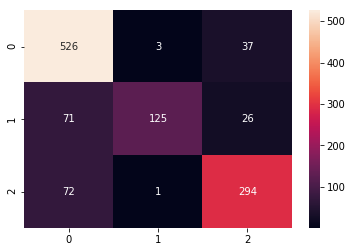

In [340]:
y_pred = mnb.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()

Logistic Regression w/Bag of Words

Training Score: 0.8879584175570314
Test Score: 0.8051948051948052
              precision    recall  f1-score   support

    Leighton       0.77      0.91      0.84       566
      Strang       0.91      0.57      0.70       222
    Van Dijk       0.83      0.78      0.80       367

   micro avg       0.81      0.81      0.81      1155
   macro avg       0.84      0.75      0.78      1155
weighted avg       0.82      0.81      0.80      1155



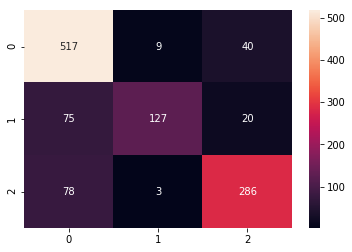

In [349]:
lrc = linear_model.LogisticRegression(C=1,solver='lbfgs',multi_class='auto', 
                                      )
lrc.fit(X_train,y_train)
print("Training Score: {}".format(lrc.score(X_train,y_train)))
print("Test Score: {}".format(lrc.score(X_test,y_test)))
y_pred = lrc.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()

So far, the logistic regression with bag of words and multinomialNB for tf-idf seem to score the highest. Lets cross validate each and see which one does better.


## Cross validation
Assess your models using cross-validation and determine whether one model performed better.

In [404]:
X = word_counts.drop(['text_sentence','text_source'],1)
y = word_counts['text_source']

In [405]:
lrccv = linear_model.LogisticRegression(C=.9,solver='lbfgs',multi_class='auto')
lrccv.fit(X,y)


LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [406]:
scores = cross_val_score(lrccv,X,y,cv=10)
print(scores)
print(scores.mean())


[0.76508621 0.7300216  0.75161987 0.75757576 0.78958785 0.79175705
 0.85032538 0.85249458 0.83947939 0.85466377]
0.7982611459185183


In [371]:
X = new_df[0]
y = new_df[1]
#fit transform td-idf
X = vectorizer.fit_transform(X)
X = X.toarray() #convert to array for modeling

mnb.fit(X,y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [364]:
scores = cross_val_score(mnb,X,y,cv=10)
print(scores)
print(scores.mean())

[0.78017241 0.70410367 0.7537797  0.73593074 0.72017354 0.79826464
 0.8329718  0.81561822 0.81344902 0.85683297]
0.7811296714282059


Pick one of the models and try to increase accuracy by at least 5 percentage points.

looks like bag of words and logistic regression is the top performer.

In [407]:
X = word_counts.drop(['text_sentence','text_source'],1)
y = word_counts['text_source']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=43)

In [417]:
lrc = linear_model.LogisticRegression(C=.9,solver='lbfgs',multi_class='auto')
lrc.fit(X_train,y_train)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Training Score: 0.9159688131677736
Test Score: 0.8233766233766234
              precision    recall  f1-score   support

    Leighton       0.81      0.91      0.86       566
      Strang       0.93      0.63      0.75       222
    Van Dijk       0.81      0.80      0.81       367

   micro avg       0.82      0.82      0.82      1155
   macro avg       0.85      0.78      0.80      1155
weighted avg       0.83      0.82      0.82      1155



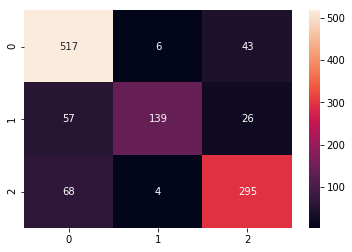

In [418]:
print("Training Score: {}".format(lrc.score(X_train,y_train)))
print("Test Score: {}".format(lrc.score(X_test,y_test)))
y_pred = lrc.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()

Training Score: 0.9500433150447589
Test Score: 0.8268398268398268
              precision    recall  f1-score   support

    Leighton       0.84      0.88      0.86       566
      Strang       0.80      0.70      0.75       222
    Van Dijk       0.82      0.81      0.82       367

   micro avg       0.83      0.83      0.83      1155
   macro avg       0.82      0.80      0.81      1155
weighted avg       0.83      0.83      0.83      1155



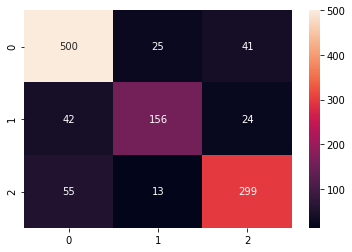

In [415]:
lrc = linear_model.LogisticRegression(C=150,solver='newton-cg',multi_class='ovr',max_iter=1000)
lrc.fit(X_train,y_train)
print("Training Score: {}".format(lrc.score(X_train,y_train)))
print("Test Score: {}".format(lrc.score(X_test,y_test)))
y_pred = lrc.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Score: 0.9477331793242852
Test Score: 0.8329004329004329
              precision    recall  f1-score   support

    Leighton       0.84      0.89      0.87       566
      Strang       0.83      0.71      0.76       222
    Van Dijk       0.82      0.82      0.82       367

   micro avg       0.83      0.83      0.83      1155
   macro avg       0.83      0.81      0.82      1155
weighted avg       0.83      0.83      0.83      1155



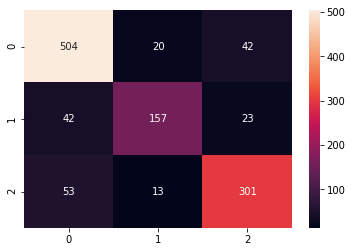

In [423]:
lrc = linear_model.LogisticRegression(C=150,solver='saga',multi_class='ovr',max_iter=1000)
lrc.fit(X_train,y_train)
print("Training Score: {}".format(lrc.score(X_train,y_train)))
print("Test Score: {}".format(lrc.score(X_test,y_test)))
y_pred = lrc.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()

In [439]:
#not much luck with bag of words, i will try with td-idf
vectorizer = TfidfVectorizer(max_df=0.7, # drop words that occur in more than half the paragraphs
                             min_df=5, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [440]:
X = new_df[0]
y = new_df[1]
#fit transform td-idf
X = vectorizer.fit_transform(X)
X = X.toarray() #convert to array for modeling
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=43)

In [454]:
mnb = naive_bayes.MultinomialNB(alpha=.7)
mnb.fit(X_train,y_train)

MultinomialNB(alpha=0.7, class_prior=None, fit_prior=True)

In [455]:
print(mnb.score(X_train,y_train))
print(mnb.score(X_test,y_test))

0.9044181345654058
0.8476190476190476


In [523]:
#not much luck with bag of words, i will try with td-idf
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [524]:
X = new_df[0]
y = new_df[1]
#fit transform td-idf
X = vectorizer.fit_transform(X)
X = X.toarray() #convert to array for modeling
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=43)

In [525]:
mnb = naive_bayes.MultinomialNB(alpha=.9)
mnb.fit(X_train,y_train)

MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True)

In [526]:
print(mnb.score(X_train,y_train))
print(mnb.score(X_test,y_test))

0.8772740398498412
0.8199134199134199


In [780]:
#not much luck with bag of words, i will try with td-idf
vectorizer = TfidfVectorizer(max_df=0.9, # drop words that occur in more than half the paragraphs
                             min_df=1, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            sublinear_tf=True)

In [781]:
X = new_df[0]
y = new_df[1]

In [782]:
X = vectorizer.fit_transform(X)
X = X.toarray() #convert to array for modeling
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=43)

In [783]:
mnb = naive_bayes.MultinomialNB(alpha=.6)
mnb.fit(X_train,y_train)

MultinomialNB(alpha=0.6, class_prior=None, fit_prior=True)

In [784]:
print(mnb.score(X_train,y_train))
print(mnb.score(X_test,y_test))

0.8946940985381701
0.8344155844155844


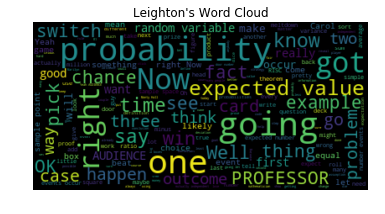

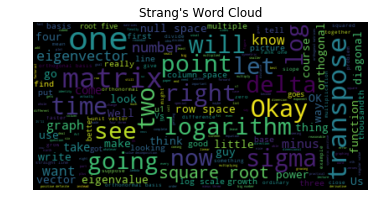

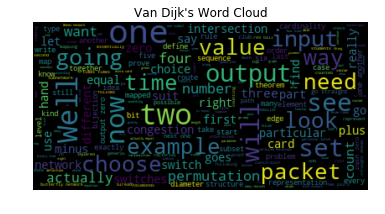

In [436]:
wordcloud = WordCloud().generate(leighton)
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(leighton)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Leighton's Word Cloud")
plt.show()

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(strang)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Strang's Word Cloud")
plt.show()

wordcloud = WordCloud(max_font_size=40).generate(vandijk)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Van Dijk's Word Cloud")
plt.show()